---
# Size-response experiment

In [1]:
from IPython.display import Image

This notebook contains an initial analysis of 1 run (`/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-3_bold.mat`) of the Size-Response experiment executed on `01/02/2022`.

In this experiment, we tune the stimulus based on the obtained parameters earlier: after fitting an `iterative` fit to our `ses-1`-pRF data, we select a best vertex using `call_targetvertex`, which is embedded in `spinoza_bestvertex` that can be called easily with `master -m 18 -s <subject>`. This outputs a `model-gauss_desc-best_vertices.csv`-file in `derivatives/pycortex/<subject>`. We then do `call_sizeresponse -s <subject>`, which takes this file, applies a divise normalization (DN-) model with `iterative fit`. Internally, it assumes that the obtained pRF size is the `average across layers`. Alessio showed earlier that the pRF-size is `smaller` in the `middle` layers, so `call_sizeresponse` creates a size-response (SR-) curve for a superficial/deep pRF (defined as the pRF-size obtained with gaussian fit) and for a middle layer pRF (defined as 80% of the superficial/deep pRF size). Then, it looks for stimulus sizes where the differences between these curves are maximal, the peaks of both curves, and the intersection of the curves to obtain ~5 stimulus sizes. These stimulus sizes are then saved in a `.npy`-file in `derivatives/pycortex/<subject>` that is read in by the `sizeresponse`-experiment. 

NOTE: because the BOLD-screen was recently moved closer to the bore, we had to adapt our stimulus location/size accordingly. Below the calculation:

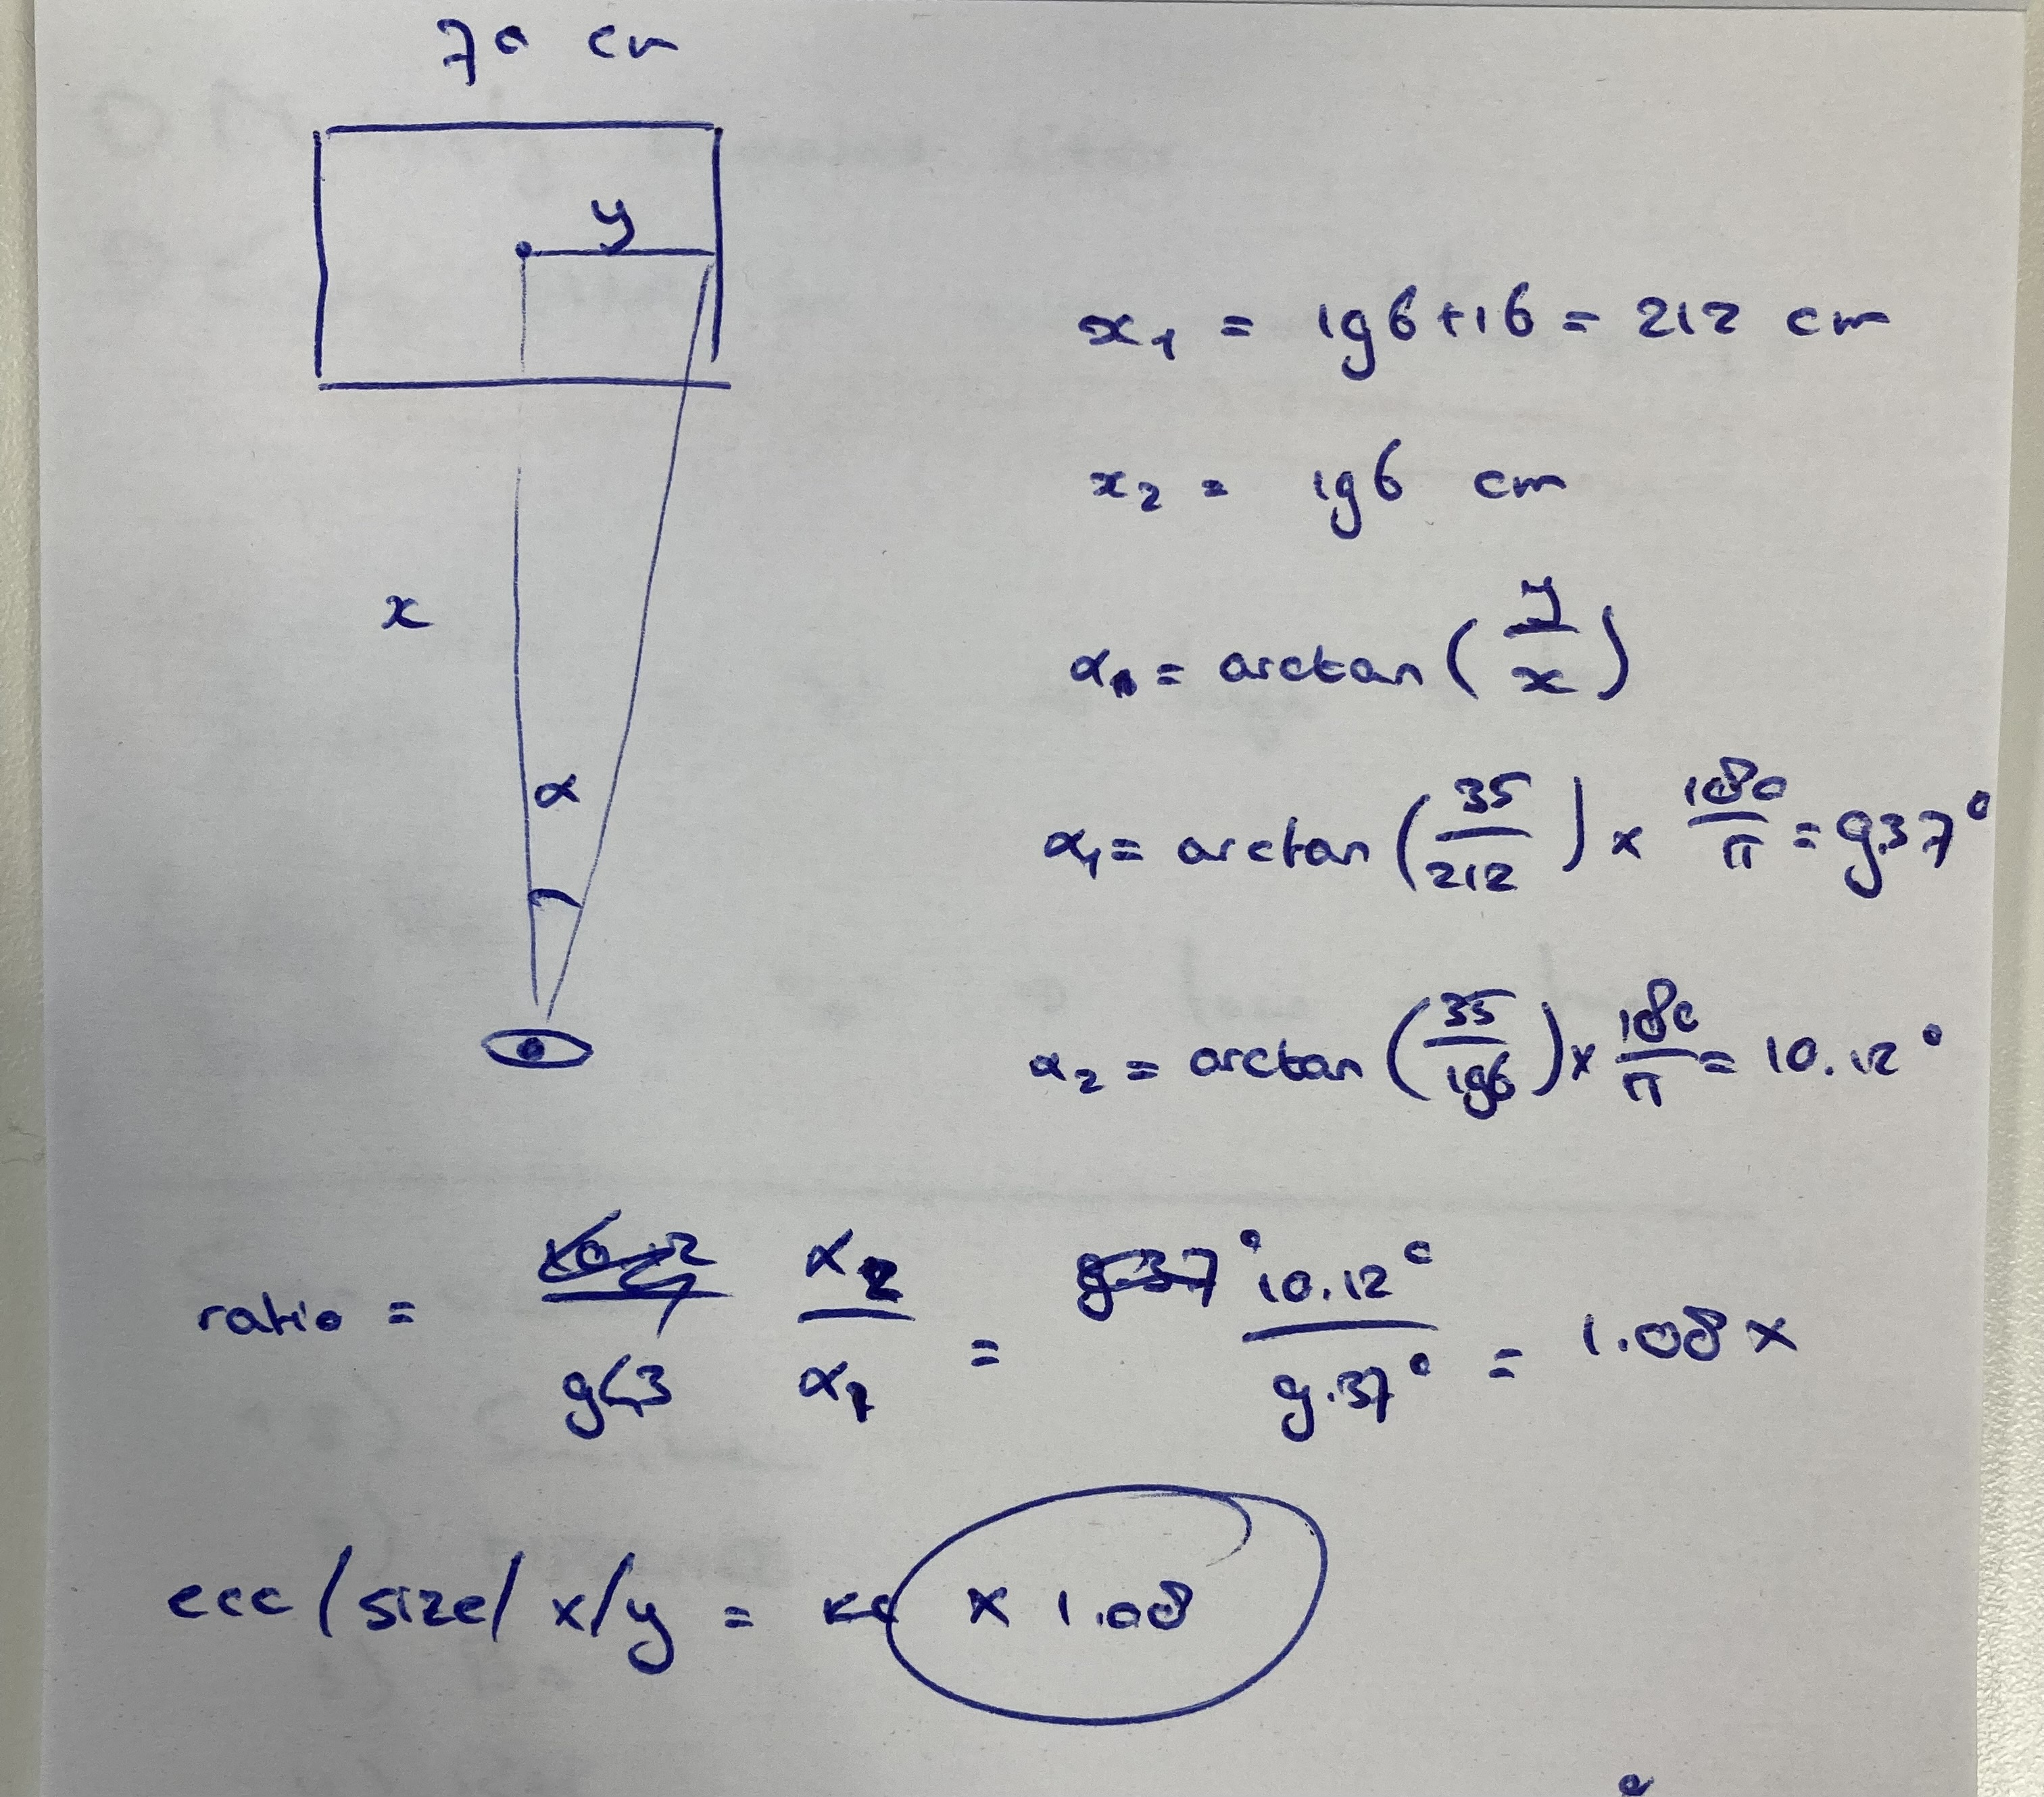

In [2]:
Image(filename="../imgs/boldscreen_increase_ratio.jpg")

This calculation shows that the x/y-location, eccentricity, and size are increased by a factor of `1.08` with the new BOLD-screen location. Therefore, the stimulus sizes and pRF-location have been updated **AFTER** running `call_sizeresponse`, so after fitting the DN-model with iterative fit.

In [2]:
%reload_ext autoreload
%autoreload 2

In [49]:
from linescanning import utils,prf,glm,dataset,plotting
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import nideconv as nd
from scipy.stats import sem
from prfpy.stimulus import PRFStimulus2D
import os
import pandas as pd
opj = os.path.join

warnings.simplefilter('ignore')
project_dir     = os.environ.get("DIR_PROJECTS")
base_dir        = opj(project_dir, 'hemifield')
deriv_dir       = opj(base_dir, 'derivatives')

plot_vox = 359
plot_xkcd = False

Fetch the files representing the functional data (`bold.mat` > `call_linerecon`), experiment log file `events.tsv` > `exptools2`), regressor file (`physio.txt`) and mat-file (`physio.mat`) physio files (`call_spmphysio`). `run_files` collects all these files in a list, from which we can then pick the required files and store them in their respective variable

In [12]:
# Load data
sub         = '003'
ses         = 3
task        = "task-SR"
runs        = [3,4,6]
func_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "func")
ribbon      = [356,363]

run_files = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", f"{task}"], func_dir)
func_file   = utils.get_file_from_substring("bold.mat", run_files)
exp_file   = utils.get_file_from_substring("events.tsv", run_files)
print(exp_file)

window = 19
order = 3

data_obj = dataset.Dataset(func_file,
                           deleted_first_timepoints=50, 
                           deleted_last_timepoints=50,
                           window_size=window, # needs to be odd
                           high_pass=True,
                           tsv_file=exp_file,
                           poly_order=order,
                           use_bids=True,
                           verbose=True)

['/mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-3_events.tsv', '/mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-4_events.tsv', '/mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-6_events.tsv']
DATASET

FUNCTIONAL
Preprocessing /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-3_bold.mat
 Cutting 50 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Savitsky-Golay low pass filter [removes high frequences] (window = 19, order = 3)
 Using low-passed [SG-filtered] data for PSC
Preprocessing /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-4_bold.mat
 Cutting 50 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Savitsky-Golay low pass filt

In [13]:
df_func     = data_obj.fetch_fmri()
df_onsets   = data_obj.fetch_onsets()
df_onsets

Fetching dataframe from attribute 'df_func_psc'


onset
subject run event_type                   
003     3   2.014613132977678   24.363776
            3.5652478065289     26.655493
            3.5652478065289     35.213706
            2.13914868391734    36.855363
            2.13914868391734    39.913720
...                                   ...
        6   1.140879298089248  382.953138
            2.13914868391734   385.328232
            2.13914868391734   387.653167
            2.014613132977678  394.244731
            2.014613132977678  395.731014

[229 rows x 1 columns]

As a side note, we can select individual runs using `utils.select_from_df`. I wrote this function because it can be quite a hassle to select particular sections from a `pandas.DataFrame`

In [14]:
run1_func = utils.select_from_df(df_func, expression=(f"run = {runs[0]}"))
run1_func

vox 0      vox 1     vox 2     vox 3      vox 4  \
subject run t                                                             
003     3   0.000   -2.866334  14.083719 -1.988107  0.113690  16.808964   
            0.105   -2.731872   7.639611 -0.292766  1.844203  10.715782   
            0.210   -2.411413   2.589464  1.009679  2.919769   5.803490   
            0.315   -1.941967  -1.205993  1.959622  3.432035   1.961720   
            0.420   -1.360548  -3.886038  2.597535  3.472650  -0.919974   
...                       ...        ...       ...       ...        ...   
            450.975  2.323198  -2.522868  1.806688  4.131079   0.005221   
            451.080  0.935221  -2.879173  2.496827  3.340364   0.540626   
            451.185 -1.249576  -2.895468  2.913606  2.415967   1.310349   
            451.290 -4.338670  -2.504259  2.987731  1.377296   2.348626   
            451.395 -8.439552  -1.638043  2.649927  0.243783   3.689718   

                        vox 5     vox 6     vox 7     vox 8     vox 9  ...  \
subject run t                                                          ...   
003     3   0.000    7.069802 -1.533657  4.556024 -3.016156  3.671980  ...   
            0.105    5.792725  0.035250  2.529812 -1.397520  2.390802  ...   
            0.210    4.708469  1.229584  0.930727 -0.235647  1.309419  ...   
            0.315    3.793085  2.084744 -0.280434  0.515652  0.412011  ...   
            0.420    3.022611  2.636099 -1.142937  0.902629 -0.317246  ...   
...                       ...       ...       ...       ...       ...  ...   
            450.975 -0.562251 -0.651824 -0.971246 -2.376860 -1.549292  ...   
            451.080 -0.700343 -0.733382  0.328851 -2.575815 -0.919849  ...   
            451.185 -0.665623 -0.726724  1.924944 -2.728111 -0.012267  ...   
            451.290 -0.408691 -0.617766  3.833735 -2.815366  1.206326  ...   
            451.395  0.119865 -0.392431  6.071937 -2.819240  2.768791  ...   

                       vox 710    vox 711    vox 712    vox 713    vox 714  \
subject run t                                                                
003     3   0.000    20.041609  -2.893972  -3.113472  28.284395  22.574759   
            0.105    13.123644  -2.338380  -3.603470  24.276043  25.938808   
            0.210     7.098806  -2.388048  -4.085654  20.256197  26.934469   
            0.315     1.935005  -2.933574  -4.515558  16.295683  25.942373   
            0.420    -2.399850  -3.865558  -4.848647  12.465286  23.343159   
...                        ...        ...        ...        ...        ...   
            450.975   1.367223  16.892731   4.745126 -18.685102 -19.655090   
            451.080   0.280285  20.415449   5.693340 -19.252127 -20.495415   
            451.185  -0.849497  24.626350   7.947314 -17.688549 -19.808828   
            451.290  -1.994359  29.576921  11.773038 -13.562769 -17.259884   
            451.395  -3.126514  35.318661  17.436504  -6.443191 -12.513166   

                       vox 715    vox 716    vox 717    vox 718    vox 719  
subject run t                                                               
003     3   0.000    11.838984   9.748781   9.124851 -28.957439  -0.681329  
            0.105     3.750193  13.243998  -2.194244 -40.782459  -2.693141  
            0.210    -2.432853  15.028024  -9.242016 -47.083084  -3.727466  
            0.315    -6.902874  15.394092 -12.620937 -48.653339  -3.936589  
            0.420    -9.852594  14.635431 -12.933511 -46.287239  -3.472793  
...                        ...        ...        ...        ...        ...  
            450.975  -3.898853  -2.823085   0.432134  -4.101414   4.093790  
            451.080  -9.931654   0.878227   1.090717  -2.618438   7.467568  
            451.185 -16.845613   6.935096   1.600945  -2.050191  12.343979  
            451.290 -24.668688  15.708661   1.935065  -2.645785  18.992222  
            451.395 -33.428848  27.560032   2.065289  -4.654318  27.681494  

[4300 rows x 720

In [15]:
run1_onsets = utils.select_from_df(df_onsets, expression=(f"run = {runs[0]}"))
run1_onsets

onset
subject run event_type                   
003     3   2.014613132977678   24.363776
            3.5652478065289     26.655493
            3.5652478065289     35.213706
            2.13914868391734    36.855363
            2.13914868391734    39.913720
...                                   ...
            2.13914868391734   372.703811
            2.13914868391734   376.503695
            2.13914868391734   386.603704
            2.13914868391734   388.230752
            2.13914868391734   392.345201

[78 rows x 1 columns]

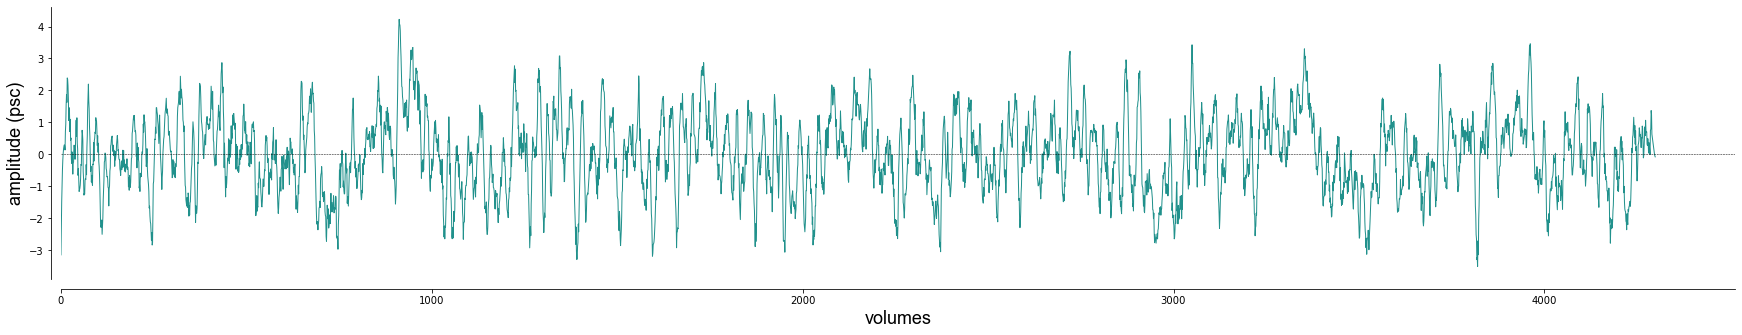

In [50]:
plotting.LazyPlot(run1_func[f'vox {plot_vox}'].values, 
                  figsize=(30,5),
                  x_label="volumes",
                  y_label="amplitude (psc)",
                  add_hline={'pos': 0, 'ls': '--', 'color': 'k', 'lw': 0.5},
                  set_xlim_zero=True,
                  sns_trim=False,
                  xkcd=plot_xkcd,
                  font_size=18)


In [17]:
# utils.LazyPlot(physio_df['hr'].values, 
#                figsize=(30,5),
#                x_label="volumes",
#                y_label="heart rate (BPM)",
#                title=f"Heart rate",
#                add_hline={'pos': physio_df['hr'].values.mean(), 'ls': '--', 'color': 'k', 'lw': 0.5},
#                set_xlim_zero=True,
#                sns_trim=False,
#                font_size=18)

# print(f"Mean heart rate = {round(physio_df['hr'].values.mean(),2)}")

---
# Generic GLM

## Only Glover HRF

In [125]:
fitters = []
dispersion = False
derivatives = False

# change this depending on the derivatives used
tstats = np.zeros((6,720,3))
    
for run in range(3):
    data = utils.select_from_df(df_func, expression=(f"run = {runs[run]}"))
    onsets = utils.select_from_df(df_onsets, expression=(f"run = {runs[run]}"))

    fitting = glm.GenericGLM(onsets, data.values, TR=data_obj.TR, osf=1000, derivative=derivatives, dispersion=dispersion, verbose=False)
    fitters.append(fitting)

    tstats[...,run] = fitting.results['tstats']

# calculate average tstats
avg_runs = tstats.mean(axis=-1)
print(avg_runs.shape)

# cut away intercept
avg_tstats_glover = [avg_runs[ii+1,...] for ii in range(avg_runs.shape[0]-1)]

max tstat (vox 609) = 6.38
max beta (vox 609) = 2.44
max tstat (vox 540) = 13.15
max beta (vox 540) = 4.7
max tstat (vox 627) = 7.37
max beta (vox 627) = 2.83
(6, 720)


In [126]:
# fitting.plot_design_matrix()

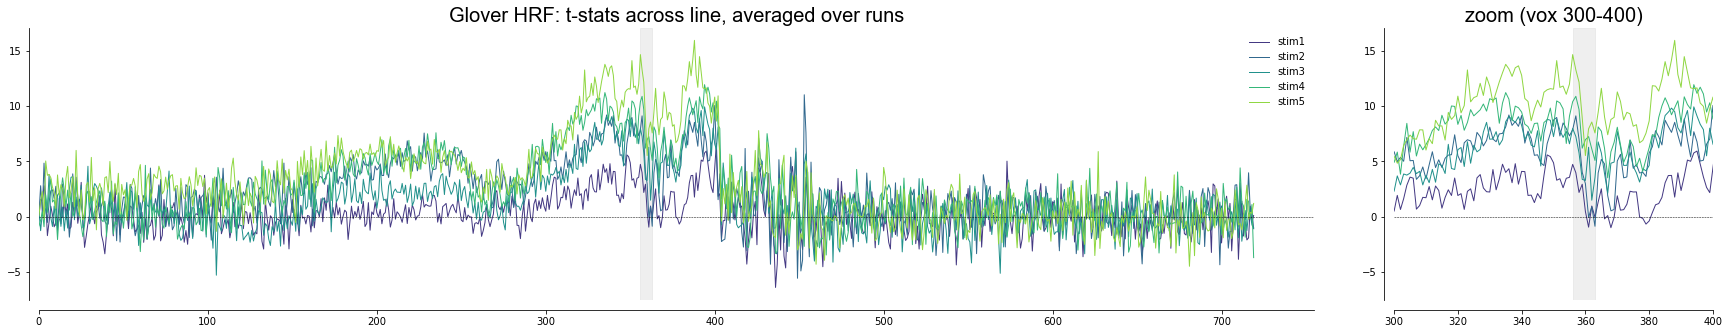

In [135]:
fig = plt.figure(figsize=(30,5))
gs = fig.add_gridspec(1,2, width_ratios=[4,1], wspace=0.1)

ax1 = fig.add_subplot(gs[0])
ax1.axvspan(*ribbon, alpha=0.3, color="#cccccc")
plotting.LazyPlot(avg_tstats_glover,
                  axs=ax1, 
                  add_hline='default', 
                  set_xlim_zero=True, 
                  sns_trim=False, 
                  title="Glover HRF: t-stats across line, averaged over runs", 
                  font_size=20, 
                  xkcd=plot_xkcd,
                  labels=[f"stim{ii+1}" for ii in range(len(fitting.condition_names))])

ax2 = fig.add_subplot(gs[1])
ax2.axvspan(*ribbon, alpha=0.3, color="#cccccc")
plotting.LazyPlot(avg_tstats_glover,
                  axs=ax2, 
                  add_hline='default', 
                  set_xlim_zero=False, 
                  sns_trim=False, 
                  title="zoom (vox 300-400)", 
                  font_size=20, 
                  x_lim=[300,400],
                  xkcd=plot_xkcd)              

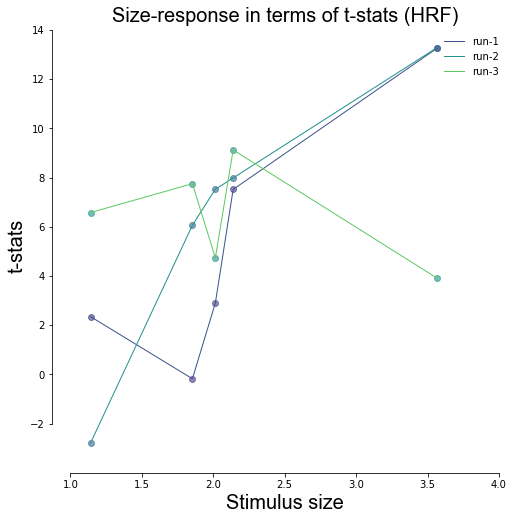

In [136]:
fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(1,1)

x = [float(ii) for ii in fitting.condition_names]
color_list = sns.color_palette('viridis', len(x))

# plot the main HRF
for idx,hrf in enumerate(['HRF']):

    ax1 = fig.add_subplot(gs[idx])

    if hrf == "HRF":
        sr_run = tstats[1:,ribbon[0]:ribbon[1],...].mean(axis=1)

    sr_ = [sr_run[...,ii] for ii in range(sr_run.shape[-1])]
    for ix, mark in enumerate(sr_):
        ax1.plot(x, mark, 'o', color=color_list[ix], alpha=0.6)

    plotting.LazyPlot(sr_,
                    xx=x,
                    axs=ax1, 
                    title=f"Size-response in terms of t-stats ({hrf})", 
                    font_size=20,
                    x_label="Stimulus size",
                    y_label="t-stats",
                    xkcd=plot_xkcd,
                    x_lim=[x[0]-0.2,x[-1]+0.5],
                    sns_trim=True,
                    labels=[f"run-{ii+1}" for ii in range(len(sr_run))])


## Glover + derivative

In [137]:
fitters = []
dispersion = False
derivatives = True

# change this depending on the derivatives used
tstats = np.zeros((11,720,3))
    
for run in range(3):
    data = utils.select_from_df(df_func, expression=(f"run = {runs[run]}"))
    onsets = utils.select_from_df(df_onsets, expression=(f"run = {runs[run]}"))

    fitting = glm.GenericGLM(onsets, data.values, TR=data_obj.TR, osf=1000, derivative=derivatives, dispersion=dispersion, verbose=False)
    fitters.append(fitting)

    tstats[...,run] = fitting.results['tstats']

# calculate average tstats
avg_runs = tstats.mean(axis=-1)
print(avg_runs.shape)

# cut away intercept
avg_tstats_glover_td = [avg_runs[ii+1,...] for ii in range(avg_runs.shape[0]-1)]

max tstat (vox 704) = 7.17
max beta (vox 704) = 3.11
max tstat (vox 672) = 8.61
max beta (vox 672) = 3.7
max tstat (vox 481) = 7.13
max beta (vox 481) = 3.09
(11, 720)


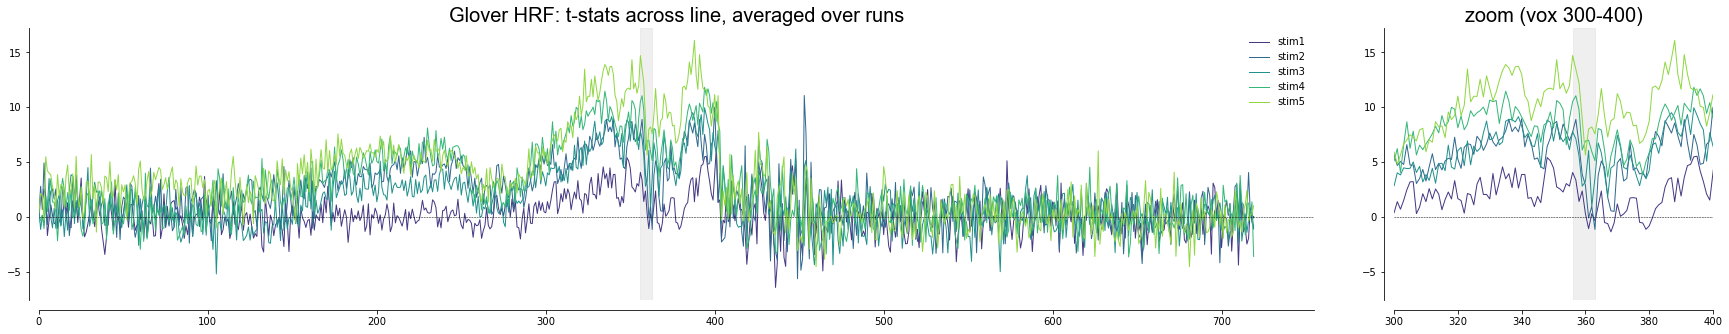

In [138]:
fig = plt.figure(figsize=(30,5))
gs = fig.add_gridspec(1,2, width_ratios=[4,1], wspace=0.1)

ax1 = fig.add_subplot(gs[0])
ax1.axvspan(*ribbon, alpha=0.3, color="#cccccc")
plotting.LazyPlot(avg_tstats_glover_td[0::2],
                  axs=ax1, 
                  add_hline='default', 
                  set_xlim_zero=True, 
                  sns_trim=False, 
                  title="Glover HRF: t-stats across line, averaged over runs", 
                  font_size=20, 
                  xkcd=plot_xkcd,
                  labels=[f"stim{ii+1}" for ii in range(len(fitting.condition_names))])

ax2 = fig.add_subplot(gs[1])
ax2.axvspan(*ribbon, alpha=0.3, color="#cccccc")
plotting.LazyPlot(avg_tstats_glover_td[0::2],
                  axs=ax2, 
                  add_hline='default', 
                  set_xlim_zero=False, 
                  sns_trim=False, 
                  title="zoom (vox 300-400)", 
                  font_size=20, 
                  x_lim=[300,400],
                  xkcd=plot_xkcd)              

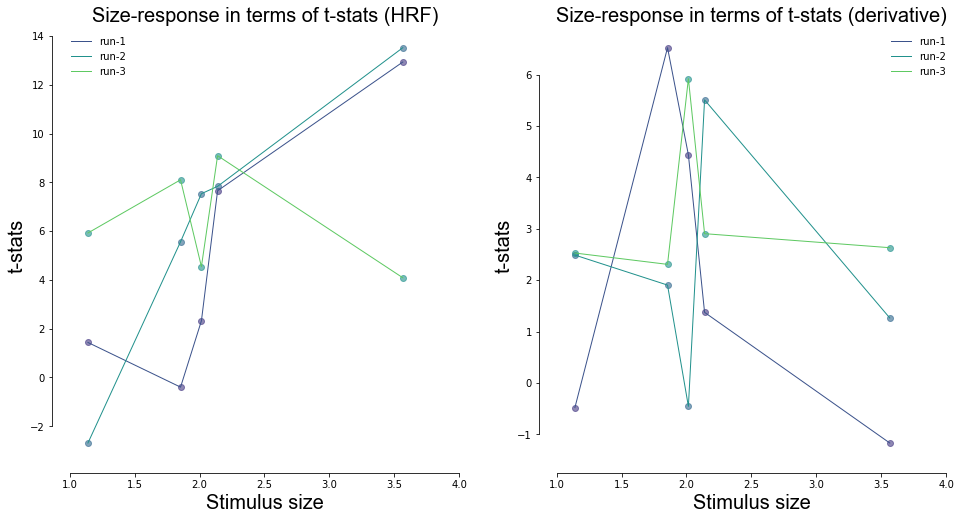

In [141]:
fig = plt.figure(figsize=(16,8))
gs = fig.add_gridspec(1,2)

x = [float(ii) for ii in fitting.condition_names]
color_list = sns.color_palette('viridis', len(x))

# plot the main HRF
for idx,hrf in enumerate(['HRF', 'derivative']):

    ax1 = fig.add_subplot(gs[idx])

    if hrf == "HRF":
        sr_run = tstats[1::2,ribbon[0]:ribbon[1],...].mean(axis=1)
    elif hrf == "derivative":
        sr_run = tstats[2::2,ribbon[0]:ribbon[1],...].mean(axis=1)

    sr_ = [sr_run[...,ii] for ii in range(sr_run.shape[-1])]
    for ix, mark in enumerate(sr_):
        ax1.plot(x, mark, 'o', color=color_list[ix], alpha=0.6)

    plotting.LazyPlot(sr_,
                    xx=x,
                    axs=ax1, 
                    title=f"Size-response in terms of t-stats ({hrf})", 
                    font_size=20,
                    x_label="Stimulus size",
                    y_label="t-stats",
                    xkcd=plot_xkcd,
                    x_lim=[x[0]-0.2,x[-1]+0.5],
                    sns_trim=True,
                    labels=[f"run-{ii+1}" for ii in range(len(sr_run))])


## Glover + derivative + dispersion

In [142]:
fitters = []
dispersion = True
derivatives = True

# change this depending on the derivatives used
tstats = np.zeros((16,720,3))
    
for run in range(3):
    data = utils.select_from_df(df_func, expression=(f"run = {runs[run]}"))
    onsets = utils.select_from_df(df_onsets, expression=(f"run = {runs[run]}"))

    fitting = glm.GenericGLM(onsets, data.values, TR=data_obj.TR, osf=1000, derivative=derivatives, dispersion=dispersion, verbose=False)
    fitters.append(fitting)

    tstats[...,run] = fitting.results['tstats']

# calculate average tstats
avg_runs = tstats.mean(axis=-1)
print(avg_runs.shape)

# cut away intercept
avg_tstats_glover_td_dd = [avg_runs[ii+1,...] for ii in range(avg_runs.shape[0]-1)]

max tstat (vox 661) = 8.95
max beta (vox 661) = 14.19
max tstat (vox 505) = 8.62
max beta (vox 505) = 15.78
max tstat (vox 626) = 6.64
max beta (vox 626) = 11.89
(16, 720)


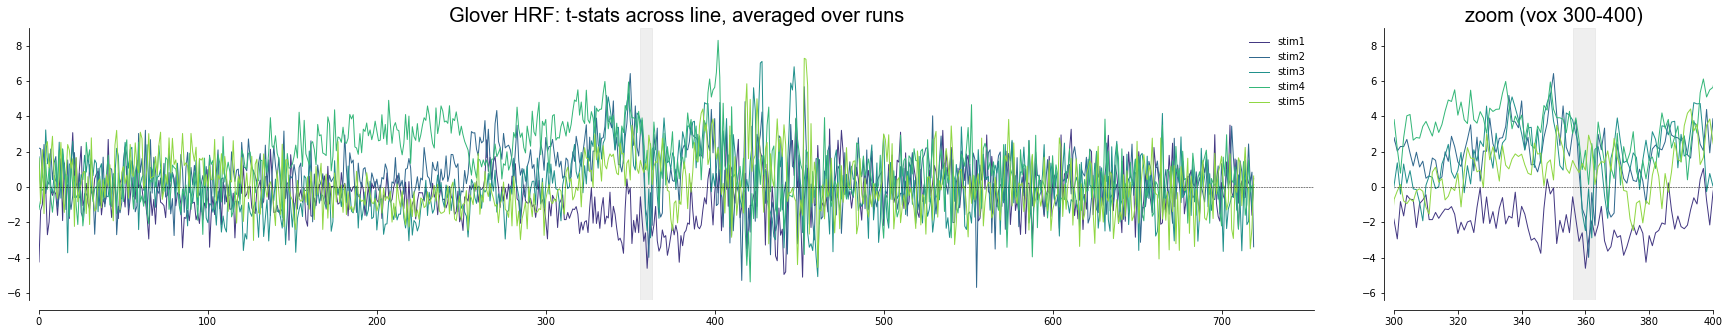

In [144]:
fig = plt.figure(figsize=(30,5))
gs = fig.add_gridspec(1,2, width_ratios=[4,1], wspace=0.1)

ax1 = fig.add_subplot(gs[0])
ax1.axvspan(*ribbon, alpha=0.3, color="#cccccc")
plotting.LazyPlot(avg_tstats_glover_td_dd[0::3],
                  axs=ax1, 
                  add_hline='default', 
                  set_xlim_zero=True, 
                  sns_trim=False, 
                  title="Glover HRF: t-stats across line, averaged over runs", 
                  font_size=20, 
                  xkcd=plot_xkcd,
                  labels=[f"stim{ii+1}" for ii in range(len(fitting.condition_names))])

ax2 = fig.add_subplot(gs[1])
ax2.axvspan(*ribbon, alpha=0.3, color="#cccccc")
plotting.LazyPlot(avg_tstats_glover_td_dd[0::3],
                  axs=ax2, 
                  add_hline='default', 
                  set_xlim_zero=False, 
                  sns_trim=False, 
                  title="zoom (vox 300-400)", 
                  font_size=20, 
                  x_lim=[300,400],
                  xkcd=plot_xkcd)              

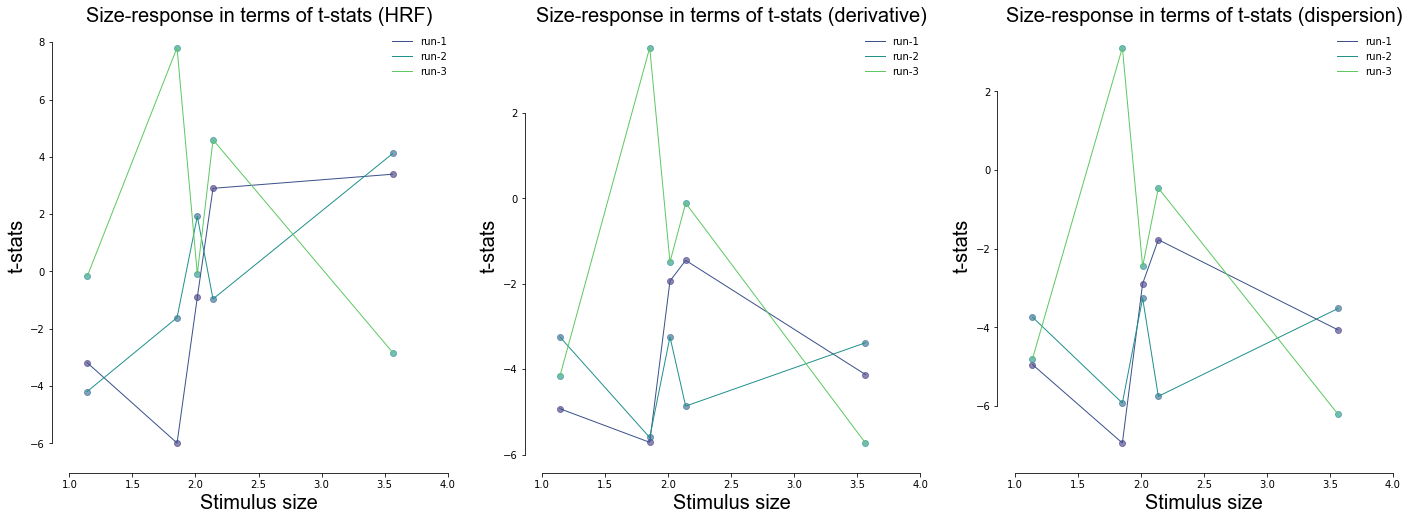

In [146]:
fig = plt.figure(figsize=(24,8))
gs = fig.add_gridspec(1,3)

x = [float(ii) for ii in fitting.condition_names]
color_list = sns.color_palette('viridis', len(x))

# plot the main HRF
for idx,hrf in enumerate(['HRF', 'derivative', 'dispersion']):

    ax1 = fig.add_subplot(gs[idx])

    if hrf == "HRF":
        sr_run = tstats[1::3,ribbon[0]:ribbon[1],...].mean(axis=1)
    elif hrf == "derivative":
        sr_run = tstats[2::3,ribbon[0]:ribbon[1],...].mean(axis=1)
    elif hrf == "dispersion":
        sr_run = tstats[3::3,ribbon[0]:ribbon[1],...].mean(axis=1)

    sr_ = [sr_run[...,ii] for ii in range(sr_run.shape[-1])]
    for ix, mark in enumerate(sr_):
        ax1.plot(x, mark, 'o', color=color_list[ix], alpha=0.6)

    plotting.LazyPlot(sr_,
                    xx=x,
                    axs=ax1, 
                    title=f"Size-response in terms of t-stats ({hrf})", 
                    font_size=20,
                    x_label="Stimulus size",
                    y_label="t-stats",
                    xkcd=plot_xkcd,
                    x_lim=[x[0]-0.2,x[-1]+0.5],
                    sns_trim=True,
                    labels=[f"run-{ii+1}" for ii in range(len(sr_run))])

# Old HRF (double-gamma, no derivatives)

In [11]:
fitters = []
tstats = np.zeros((6,720,3))
for run in range(3):
    data = utils.select_from_df(df_func, expression=(f"run = {runs[run]}"))
    onsets = utils.select_from_df(df_onsets, expression=(f"run = {runs[run]}"))

    fitting = glm.GenericGLM(onsets, data.values, TR=data_obj.TR, osf=1000, derivative=True, verbose=True)
    fitters.append(fitting)

    tstats[...,run] = fitting.results['tstats']

# calculate average tstats
avg_runs = tstats.mean(axis=-1)
print(avg_runs.shape)
avg_tstats = [avg_runs[ii+1,...] for ii in range(avg_runs.shape[0]-1)]

Creating stimulus vector(s)
Defining HRF
Convolve stimulus vectors with HRF
Resample convolved stimulus vectors
Creating design matrix
Running fit
max tstat (vox 545) = 6.91
max beta (vox 545) = 2.72
Creating stimulus vector(s)
Defining HRF
Convolve stimulus vectors with HRF
Resample convolved stimulus vectors
Creating design matrix
Running fit
max tstat (vox 540) = 14.16
max beta (vox 540) = 5.26
Creating stimulus vector(s)
Defining HRF
Convolve stimulus vectors with HRF
Resample convolved stimulus vectors
Creating design matrix
Running fit
max tstat (vox 627) = 8.0
max beta (vox 627) = 3.21
(6, 720)


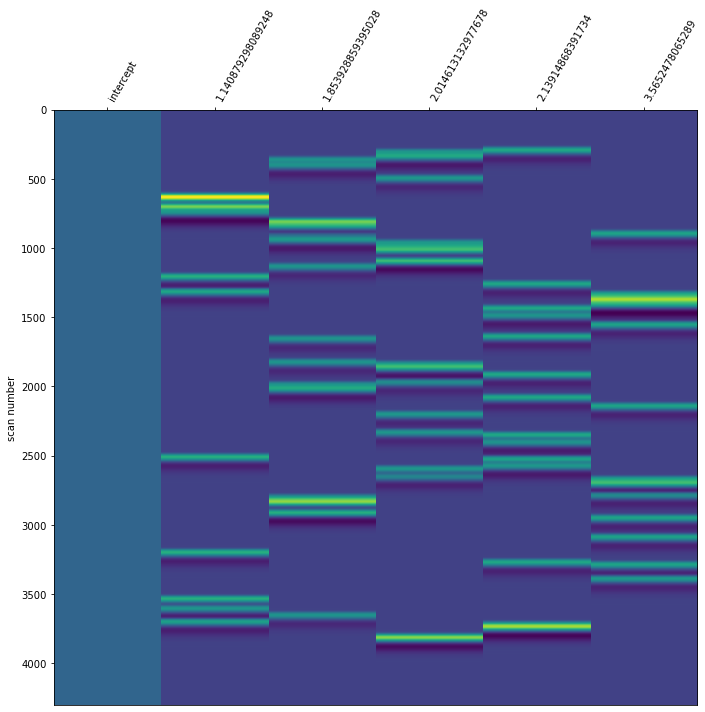

In [12]:
fitting.plot_design_matrix()

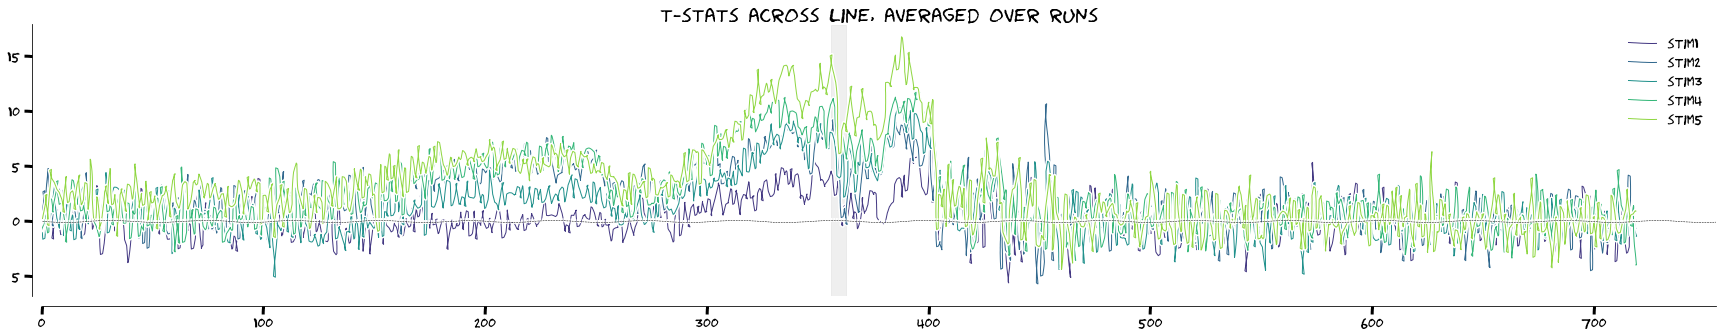

In [13]:
fig, axs = plt.subplots(figsize=(30,5))
axs.axvspan(*ribbon, alpha=0.3, color="#cccccc")
plotting.LazyPlot(avg_tstats,
                  axs=axs, 
                  add_hline='default', 
                  set_xlim_zero=True, 
                  sns_trim=False, 
                  title="t-stats across line, averaged over runs", 
                  font_size=20, 
                  xkcd=plot_xkcd,
                  labels=[f"stim{ii+1}" for ii in range(len(fitting.condition_names))])

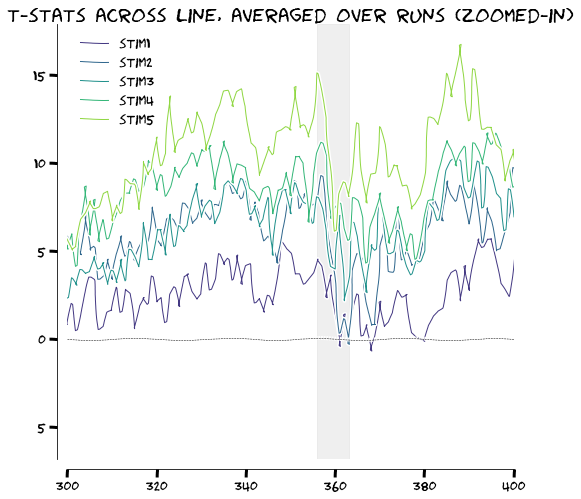

In [14]:
fig, axs = plt.subplots(figsize=(8,8))
axs.axvspan(*ribbon, alpha=0.3, color="#cccccc")
plotting.LazyPlot(avg_tstats,
                  axs=axs, 
                  add_hline='default', 
                  set_xlim_zero=False, 
                  sns_trim=False, 
                  title="t-stats across line, averaged over runs (zoomed-in)", 
                  font_size=20, 
                  x_lim=[300,400],
                  xkcd=plot_xkcd,
                  labels=[f"stim{ii+1}" for ii in range(len(fitting.condition_names))])

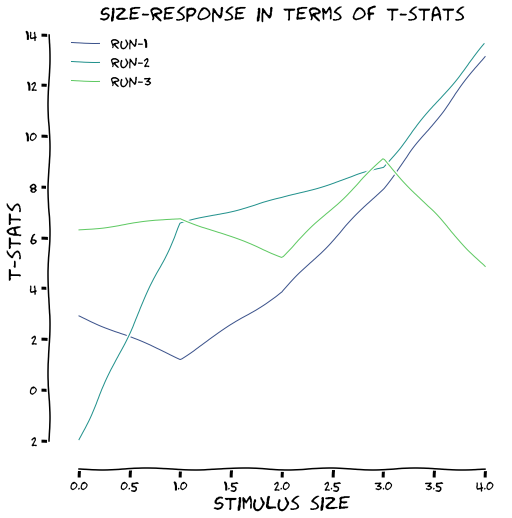

In [15]:
sr_run = tstats[1:,ribbon[0]:ribbon[1],...].mean(axis=1)
sr_ = [sr_run[...,ii] for ii in range(sr_run.shape[-1])]


plotting.LazyPlot(sr_,
                  figsize=(8,8), 
                  set_xlim_zero=False, 
                  sns_trim=True, 
                  title="Size-response in terms of t-stats", 
                  font_size=20,
                  x_label="Stimulus size",
                  y_label="t-stats",
                  xkcd=plot_xkcd,
                  labels=[f"run-{ii+1}" for ii in range(len(sr_run))])

The Gauss-Markov theorem states that in order for OLS to yield valid estimates (including estimates of the parameters’ standard errors) _the errors (residuals) have a mean of 0_, _have 0 covariance (i.e., are uncorrelated)_, and _have equal variance_ (source: https://lukas-snoek.com/NI-edu/fMRI-introduction/week_4/temporal_preprocessing.html#assumption-of-zero-mean-of-the-residuals).

In [16]:
for ix, fit in enumerate(fitters):
    mean_resids = fit.results['resids'].mean()
    print(f"Mean of residuals run-{ix+1}: %3.f" % mean_resids)

Mean of residuals run-1:   0
Mean of residuals run-2:  -0
Mean of residuals run-3:   0


So, let’s check visually whether the assumption of equal variance of our residuals roughly holds for our (simulated) fMRI data. Now, when we consider this assumption in the context of our fMRI data, the assumption of “equal variance of the residuals” (also called homoskedasticity) means that we assume that the “error” in the model is equally big across our timeseries data. In other words, the mis-modelling (error) should be constant over time.

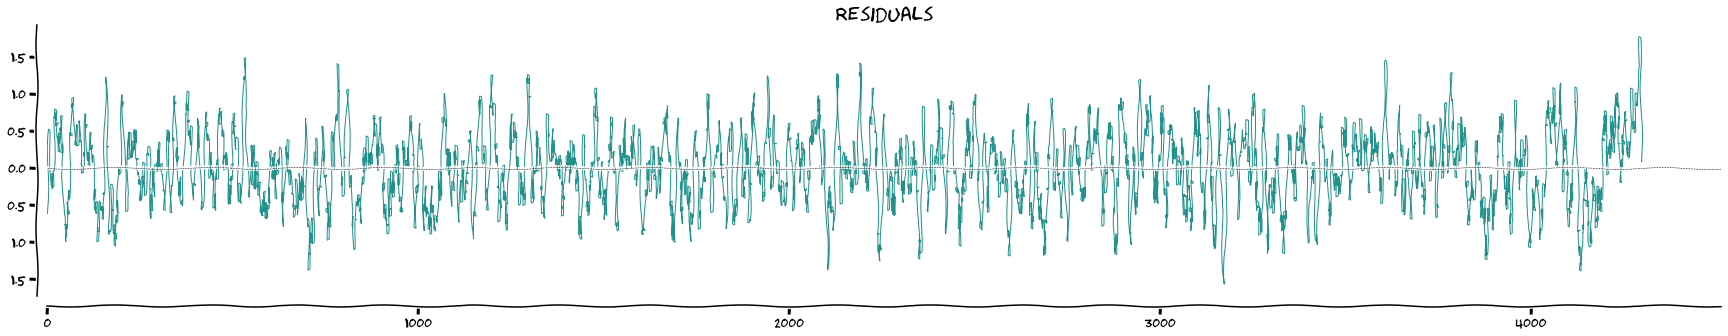

In [17]:
plotting.LazyPlot(fitting.results['resids'][:,359], 
                  figsize=(30,5), 
                  add_hline='default', 
                  set_xlim_zero=True, 
                  sns_trim=False, 
                  title="Residuals", 
                  xkcd=plot_xkcd,
                  font_size=20)

Looks quite alright! Sure, there is some variation here and there, but given that our estimates (including the residuals and their variance!) are imperfect, this suffices.

---
# Deconvolution

## Size-Response information

Here we fetch relevant pRF-parameters that are required to construct the size-response curve below (this is the same curve as in `derivatives/pycortex/<subject>/<subject>_hemi-?_desc-prf_sizeresponse.pdf`).

In [59]:
# collect subject data including Normalization parameters
subject_info = utils.CollectSubject(f"sub-{sub}", prf_dir=opj(deriv_dir, 'prf', f"sub-{sub}", 'ses-1'), cx_dir=opj(deriv_dir, 'pycortex', f"sub-{sub}"), settings='recent', hemi="lh", model="norm")

# initiate the SizeResponse class
SR = prf.SizeResponse(subject_info.prf_stim, subject_info.normalization_params, subject_info=subject_info)

# make the stimuli
SR.make_stimuli()

# make the curve
sr_curve1 = SR.make_sr_function(center_prf=True)

# stimsizes are in SR.stims_fill_sizes

Using settings file: /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-003/ses-1/20220210_model-norm_desc-settings.yml


Perform the deconvolution using nideconv. For now, the physio-regressors are excluded because they look unreliable (see plot of heart rate above..). There might have been something wrong with the PPU/Resp acquisition, but best to leave them out until we have a run with good physiology

## Model: no differentation between stimulus size

In [19]:
# create onset df with no differentiation between stimulus sizes > consider ALL stimulus sizes as 1 event type
all_stim_onsets = df_onsets.copy().reset_index()
all_stim_onsets['event_type'] = 'stim'
all_stim_onsets = all_stim_onsets.set_index(['subject', 'run', 'event_type'])
all_stim_onsets

onset
subject run event_type            
003     3   stim         24.363776
            stim         26.655493
            stim         35.213706
            stim         36.855363
            stim         39.913720
...                            ...
        6   stim        382.953138
            stim        385.328232
            stim        387.653167
            stim        394.244731
            stim        395.731014

[229 rows x 1 columns]

First, we run a deconvolution without differentiation between stimulus sizes: all events are considered the same, so we should get 1 HRF out. Theoretically, this should already scale with cortical depth

In [20]:
# use 1 run for now, concatenating runs doesn't work yet and makes ridge regression complicated
use_data    = df_func.copy()
use_onsets  = all_stim_onsets.copy()

# # 1 run
# use_data = utils.select_from_df(df_func.copy(), expression="run = 1")
# onset_onsets = utils.select_from_df(all_stim_onsets.copy(), expression="run = 1", index=['subject', 'run', 'event_type'])

# CSF/GM >> GM/WM
ribbon      = [356,363]
include_vox = np.arange(*ribbon)

min_int     = 0
max_int     = 12
n_regres    = 19
basis_sets  = "fourier"
fs          = 1/data_obj.TR

# don't use physio regressors > they're iffy
use_physio = False
if use_physio:
    physio_conf = physio_df.copy()
else:
    physio_conf = None

if basis_sets == "fir":

    print("Performing FIR with ridge regression")
    input_signal = pd.DataFrame(use_data)
    onsets = use_onsets.reset_index().drop(['subject', 'run'], axis=1).set_index('event_type').loc['stim'].onset
    
    ridge_models = {}
    for ix, signal in enumerate(input_signal.columns):
        if ix in include_vox:
            print(f" vox: {ix}")
            vox_signal = pd.DataFrame(input_signal.iloc[:,ix]).reset_index()
            vox_signal = vox_signal.drop(['subject', 'run'], axis=1).set_index('t')
            
            g_model = nd.ResponseFitter(input_signal=vox_signal, sample_rate=fs)

            # define events
            cond = use_onsets.reset_index().event_type.unique()
            cond = np.array(sorted([i for i in cond if i != 'nan']))

            # add events to model
            [g_model.add_event(str(i),
                               onsets=onsets,
                               basis_set=basis_sets,
                               n_regressors=n_regres,
                               interval=[min_int,max_int]) for i in cond]

            # fit
            g_model.fit(type="ridge")
            ridge_models[ix] = g_model
            
    print("Done")

else:
    print("Using Fourier basis sets")
    # initiate model
    fourier_model = nd.GroupResponseFitter(use_data,
                                           use_onsets,
                                           input_sample_rate=fs,
                                           concatenate_runs=False,
                                           confounds=physio_conf, 
                                           add_intercept=False)

    # define events
    cond = all_stim_onsets.reset_index().event_type.unique()
    cond = np.array(sorted([i for i in cond if i != 'nan']))
    print(f"Conditions are: {cond}")

    # add events to model
    [fourier_model.add_event(str(i),
                             basis_set=basis_sets,
                             n_regressors=n_regres,
                             interval=[min_int,max_int]) for i in cond]

    # fit
    fourier_model.fit(type="ols")
    print("Done")

    # extract condition wise timecourses
    tc_condition = fourier_model.get_conditionwise_timecourses()
    tc_error = fourier_model.get_subjectwise_timecourses().groupby(level=['event type', 'covariate', 'time']).sem()
    
    # extract time axis > only works this way with 1 event.
    time_axis = tc_condition.reset_index()['time'].values

Using Fourier basis sets
Conditions are: ['stim']
Done


In [21]:
tc_condition

vox 0     vox 1     vox 2     vox 3  \
event type covariate time                                                
stim       intercept 0.000000  -0.084297  0.194345  0.117773  0.022098   
                     0.005252  -0.086014  0.194853  0.118389  0.022573   
                     0.010505  -0.087740  0.195357  0.119016  0.023065   
                     0.015757  -0.089474  0.195856  0.119656  0.023571   
                     0.021009  -0.091217  0.196350  0.120308  0.024093   
...                                  ...       ...       ...       ...   
                     11.943738 -0.077526  0.192268  0.115428  0.020359   
                     11.948991 -0.079204  0.192794  0.115997  0.020768   
                     11.954243 -0.080892  0.193315  0.116578  0.021195   
                     11.959495 -0.082590  0.193833  0.117170  0.021638   
                     11.964748 -0.084297  0.194345  0.117773  0.022098   

                                   vox 4     vox 5     vox 6     vox 7  \
event type covariate time                                                
stim       intercept 0.000000   0.012307  0.050995  0.014083  0.129907   
                     0.005252   0.011543  0.055364  0.011600  0.131399   
                     0.010505   0.010769  0.059735  0.009149  0.132886   
                     0.015757   0.009987  0.064106  0.006730  0.134367   
                     0.021009   0.009196  0.068476  0.004342  0.135841   
...                                  ...       ...       ...       ...   
                     11.943738  0.015266  0.033565  0.024312  0.123885   
                     11.948991  0.014541  0.037913  0.021711  0.125398   
                     11.954243  0.013806  0.042268  0.019139  0.126906   
                     11.959495  0.013061  0.046630  0.016596  0.128409   
                     11.964748  0.012307  0.050995  0.014083  0.129907   

                                   vox 8     vox 9  ...   vox 710   vox 711  \
event type covariate time                           ...                       
stim       intercept 0.000000  -0.047405  0.019795  ...  0.273488  0.093912   
                     0.005252  -0.048107  0.018877  ...  0.280379  0.091718   
                     0.010505  -0.048794  0.017978  ...  0.287235  0.089699   
                     0.015757  -0.049466  0.017099  ...  0.294054  0.087852   
                     0.021009  -0.050121  0.016241  ...  0.300833  0.086175   
...                                  ...       ...  ...       ...       ...   
                     11.943738 -0.044465  0.023651  ...  0.245622  0.104455   
                     11.948991 -0.045219  0.022661  ...  0.252629  0.101551   
                     11.954243 -0.045961  0.021688  ...  0.259610  0.098827   
                     11.959495 -0.046690  0.020732  ...  0.266564  0.096281   
                     11.964748 -0.047405  0.019795  ...  0.273488  0.093912   

                                 vox 712   vox 713   vox 714   vox 715  \
event type covariate time                                                
stim       intercept 0.000000   0.049175 -0.251362  0.181281 -0.166816   
                     0.005252   0.053792 -0.245743  0.180539 -0.177505   
                     0.010505   0.058284 -0.239911  0.179739 -0.188224   
                     0.015757   0.062650 -0.233869  0.178882 -0.198971   
                     0.021009   0.066888 -0.227618  0.177968 -0.209743   
...                                  ...       ...       ...       ...   
                     11.943738  0.029477 -0.271675  0.183661 -0.124415   
                     11.948991  0.034583 -0.266924  0.183156 -0.134957   
                     11.954243  0.039569 -0.261954  0.182590 -0.145540   
                     11.959495  0.044433 -0.256766  0.181965 -0.156160   
                     11.964748  0.049175 -0.251362  0.181281 -0.166816   

                                 vox 716   vox 717   vox 718   vox 719  
event type covariate time                    

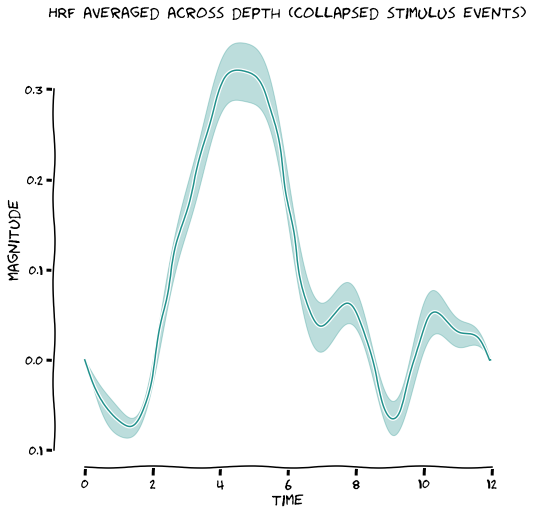

In [22]:
df_fourier = fourier_model.get_conditionwise_timecourses()
fourier = []
for idx, ii in enumerate(range(*ribbon)):
    tc_fourier = df_fourier.loc['stim'][f'vox {ii}'].values
    tc_fourier += abs(tc_fourier[0])
    fourier.append(tc_fourier)

# average over voxels
fourier_avg     = np.array(fourier).mean(axis=0)
fourier_sem     = sem(fourier)

plotting.LazyPlot(fourier_avg,
                  xx=time_axis,
                  error=fourier_sem,
                  figsize=(8,8),
                  x_label="time",
                  y_label="magnitude",
                  font_size=16,
                  title="HRF averaged across depth (collapsed stimulus events)",
                  xkcd=plot_xkcd,
                  line_width=1.5)

### FIR w/ Ridge regression vs Fourier basis sets

First I averaged over the grey-matter voxels to get 1 HRF:

In [23]:
# # try:
# if bool(ridge_models):

#     fig = plt.figure(figsize=(30,20))
#     gs = fig.add_gridspec(1,2)

#     ax1 = fig.add_subplot(gs[0])
#     sns.heatmap(ridge_models[include_vox[0]].X, ax=ax1)
#     ax1.set_title("Design matrix FIR w/ ridge regression", fontsize=16)

    
#     df_fourier = fourier_model.get_conditionwise_timecourses()
#     fourier = []
#     ridge   = []
#     for idx, ii in enumerate(range(*ribbon)):            
#         tc_ridge = ridge_models[ii].get_timecourses().values
#         ridge.append(tc_ridge)

#         tc_fourier = df_fourier.loc['stim'][f'vox {ii}'].values
#         fourier.append(tc_fourier)

#     # average over voxels
#     ridge_avg       = np.squeeze(np.array(ridge).mean(axis=0))
#     ridge_sem       = np.squeeze(sem(ridge))
#     fourier_avg     = np.array(fourier).mean(axis=0)
#     fourier_sem     = sem(fourier)

#     ax2 = fig.add_subplot(gs[1])
#     utils.LazyPlot([ridge_avg, fourier_avg],
#                     xx=time_axis,
#                     error=[ridge_sem, fourier_sem],
#                     axs=ax2,
#                     x_label="time",
#                     y_label="magnitude",
#                     font_size=16,
#                     title="HRF averaged across depth (collapsed stimulus events)",
#                     line_width=1.5,
#                     labels=['FIR ridge', 'fourier'])

#     print("Performed with ridge regression")
# # except Exception:
# #     print("Run ridge regression first.")

Below the HRFs for each voxel in the ribbon

Performed with Fourier basis sets


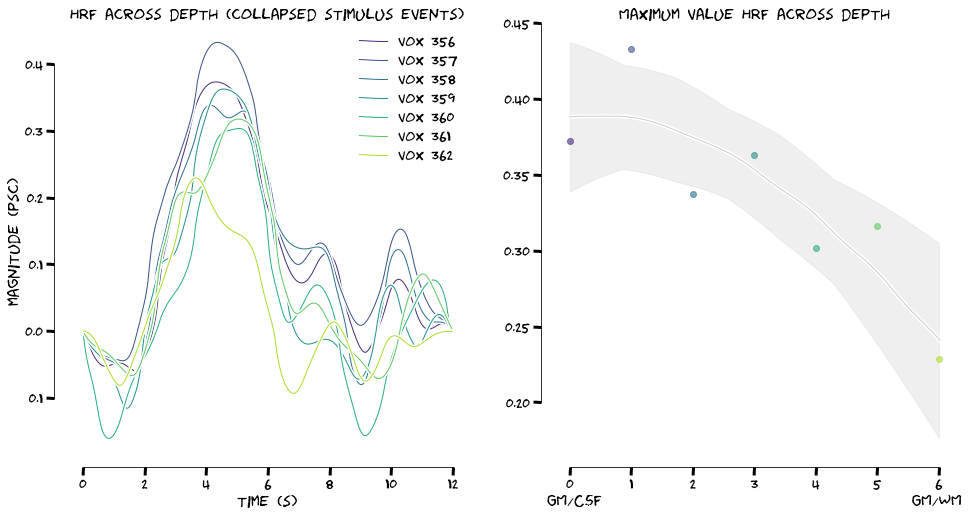

In [35]:
from scipy.optimize import curve_fit

# try:
df_fourier = fourier_model.get_conditionwise_timecourses()
fourier = []
for idx, ii in enumerate(range(*ribbon)):

    tc_fourier = df_fourier.loc['stim'][f'vox {ii}'].values
    tc_fourier += abs(tc_fourier[0])
    fourier.append(tc_fourier)

labels = [f'vox {ii}' for ii in include_vox]

fig = plt.figure(figsize=(16,8))
gs = fig.add_gridspec(1,2)

ax = fig.add_subplot(gs[0])

# if we put LazyPlot in `img`, we get access to `color_list`, which we can then use to color the markers
img = plotting.LazyPlot(fourier,
                        xx=time_axis,
                        axs=ax,
                        x_label="time (s)",
                        y_label="magnitude (psc)",
                        font_size=16,
                        title="HRF across depth (collapsed stimulus events)",
                        line_width=1,
                        xkcd=plot_xkcd,
                        labels=labels)

max_vals = np.array([np.amax(fourier[ii]) for ii in range(len(fourier))])
cf = utils.CurveFitter(max_vals, order=3, verbose=False)
ax = fig.add_subplot(gs[1])

for ix,mark in enumerate(max_vals):
    ax.plot(cf.x[ix], mark, 'o', color=img.color_list[ix], alpha=0.6)

plotting.LazyPlot(cf.y_pred_upsampled,
                  xx=cf.x_pred_upsampled,
                  axs=ax,
                  error=cf.ci_upsampled,
                  color="#cccccc",
                  x_label="GM/CSF                                        GM/WM",
                  font_size=16,
                  title="Maximum value HRF across depth",
                  xkcd=plot_xkcd,
                  line_width=1)

print("Performed with Fourier basis sets")
# except Exception:
#     print("Run ridge regression first.")

## Model: each stimulus size = event (fourier)

In [25]:
min_int     = 0
max_int     = 12
n_regres    = 19
basis_sets  = "fourier"
fs          = 1/data_obj.TR

use_physio = False
if use_physio:
    physio_conf = physio_df.copy()
else:
    physio_conf = None

g_model = nd.GroupResponseFitter(df_func,
                                 df_onsets,
                                 input_sample_rate=fs,
                                 concatenate_runs=False,
                                 confounds=physio_conf, 
                                 add_intercept=False)

cond = df_onsets.reset_index().event_type.unique()
cond = np.array(sorted([i for i in cond if i != 'nan']))
print(f"Conditions are: {cond}")
[g_model.add_event(str(i),
                   basis_set='fourier',
                   n_regressors=n_regres,
                   interval=[min_int,max_int]) for i in cond]
           
g_model.fit()
print("Done")

Conditions are: ['1.140879298089248' '1.853928859395028' '2.014613132977678'
 '2.13914868391734' '3.5652478065289']
Done


Here I reset the index of the deconvolution dataframe, so that I can use `.loc` to select timecourses of specific voxels based on `event type`.

Below is the procedure for getting the average response across the ribbon in response to the different stimulus sizes. First, I specify the voxels that are part of the cortical ribbon, eg., `[356,364]`. Then, I loop through the voxel IDs, extract the HRF-timecourse, and average this. Because of the list-nature of the output, I can use `LazyPlot` quite easily to plot it. I also extract the `maximum value` of the `averaged HRF` to plot on the size-response function. Ideally, this should lie, in order from smallest stimulus size to largest stimuls size, on the size response curve.

In [44]:
# fetch condition-wise timecourses
tc_condition    = g_model.get_conditionwise_timecourses()
time_axis       = tc_condition.groupby('time').mean().reset_index()['time'].values

ribbon          = [356,363]
stim_avg        = []
stim_sem        = []
for size_ix, sizes in enumerate(cond):

    # stimulus-specific average
    voxel_avg = []
    for ii in range(*ribbon):
        tc = tc_condition.loc[sizes][f'vox {ii}'].values
        tc += abs(tc[0])
        voxel_avg.append(tc)

    # average over voxels
    voxel_avg = np.array(voxel_avg).mean(axis=0)
    stim_sem.append(sem(voxel_avg))
    stim_avg.append(voxel_avg)

# normalize HRFs
voxel_avg_norm = voxel_avg/np.amax(stim_avg)

# get max amplitude so they're comparable to size-response magnitude
max_vals = np.amax(stim_avg/np.amax(stim_avg), axis=1)
print(max_vals.shape)

(5,)


The stimulus sizes on which the SR-curve is based were not corrected for the displacement of the BOLD-screen. Therefore, we need to reduce the stimulus-sizes by a factor of 1.08 (see calculation at the top of the page).

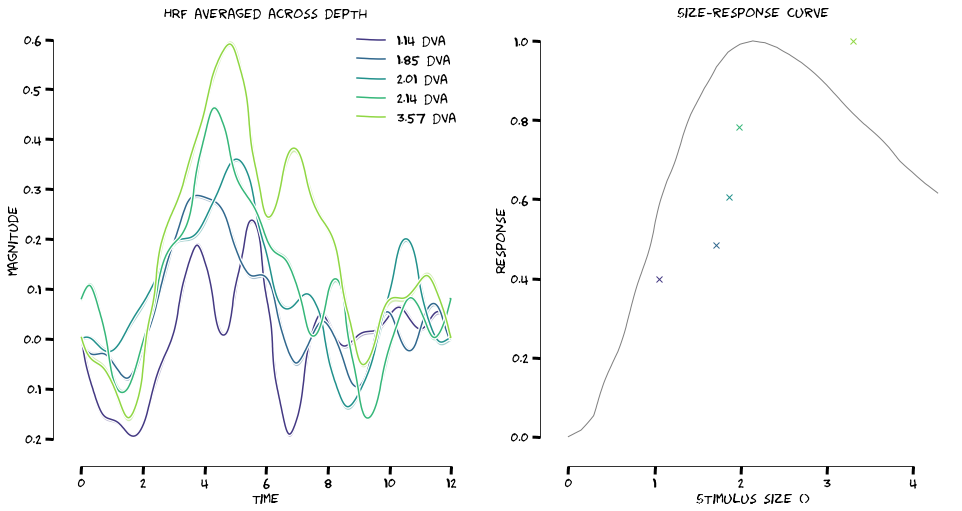

In [45]:
fig = plt.figure(figsize=(16,8))
gs = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(gs[0])
img = plotting.LazyPlot(stim_avg,
                        xx=time_axis,
                        error=stim_sem,
                        axs=ax1,
                        x_label="time",
                        y_label="magnitude",
                        font_size=14,
                        title="HRF averaged across depth",
                        line_width=1.5,
                        xkcd=plot_xkcd,
                        labels=[f"{round(float(ii),2)} dva" for ii in cond])

ax2 = fig.add_subplot(gs[1])
plotting.LazyPlot(sr_curve1, 
                  xx=SR.stims_fill_sizes,
                  color=(128/255, 128/255, 128/255),
                  axs=ax2,
                  y_label="Response",
                  x_label="Stimulus size (°)",
                  title="Size-response curve",
                  xkcd=plot_xkcd,
                  font_size=14)

for ix,kk in enumerate(max_vals):
    ax2.plot(cond.astype(float)[ix]/1.08, kk, color=img.color_list[ix], marker='x')               

Above we can see pretty decent HRF-responses in the left panel. We see that the largest stimulus size evokes the largest HRF with smaller stimulus sizes having lower HRF amplitudes. Despite that this is expected, I think it's still cool and promising. As for the SR-curve, we can see that the order is correct: smaller stimulus sizes = lower HRF. However, the normalized amplitudes are somewhat shifted compared to where we expected them to be based on the SR-curve. This is because of the way I normalized the maximums of the HRFs. See [this](https://github.com/spinoza-centre/pRFline/issues/4#issuecomment-1028001384) issue in the `pRFline`-repository.

Below I plotted the HRF for each voxel in the cortical ribbon in response to all stimulus sizes:

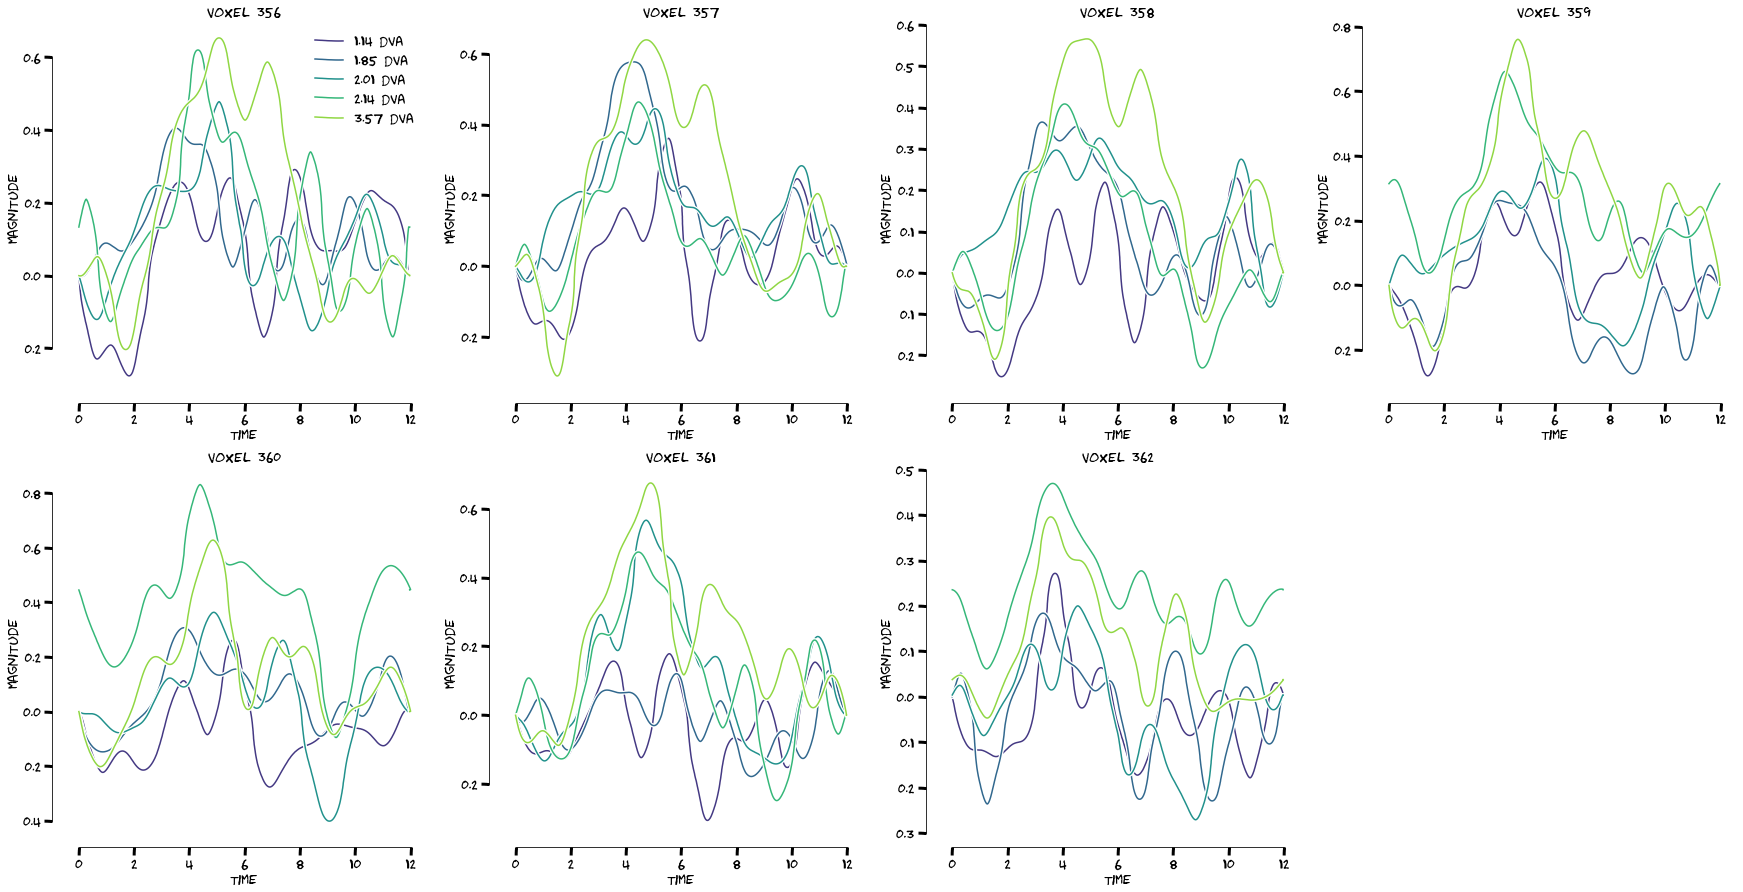

In [46]:
vox = np.arange(*ribbon)

fig = plt.figure(figsize=(30,15))
gs = fig.add_gridspec(2,(len(vox)//2)+1)
for ix,voxel in enumerate(vox):

    # fetch data from specific voxel for each stimulus size
    data = []
    for idc,size in enumerate(cond):
        vox_data = tc_condition[f'vox {voxel}'][size].values
        vox_data += vox_data[0]
        data.append(vox_data)

    # draw legend once
    if ix == 0:
        labels = [f"{round(float(ii),2)} dva" for ii in cond]
    else:
        labels = None
    
    # plot all stimulus sizes for a voxel
    ax = fig.add_subplot(gs[ix])
    plotting.LazyPlot(data,
                      xx=time_axis,
                      axs=ax,
                      x_label="time",
                      y_label="magnitude",
                      font_size=14,
                      title=f"voxel {voxel}",
                      line_width=1.5,
                      labels=labels,
                      xkcd=plot_xkcd)